<a href="https://colab.research.google.com/github/GabeRichmond/tagalog-bert-comparative-analysis/blob/main/Prediction_%7C_Performance_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Text Classification with the Hate Speech Dataset
## **Prediction / Performance Evaluation Notebook**

*A Comparative Analysis of Quantized and Non-Quantized BERT Model Performance for the Low-Resource Tagalog Language through Binary Text Classification*

Group NRS
*   NGO, Gabriel Richmond R.
*   REYES, Aramis Faye D.
*   SANTIAGO, Spencer Ivan S.

In [ ]:
# Model Name
model_name = 'jcblaise/bert-tagalog-base-uncased'

# Enable/Disable Loading of Quantized Model
quantized = True

#### **Imports**

In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive/')

# Huggingface Transformers
!pip install transformers
import transformers
from transformers import BertModel

# Matplotlib
import matplotlib.pyplot as plt

# NumPy
import numpy as np

# Pandas
import pandas as pd

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# Seaborn
import seaborn as sns

# Sklearn
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TQDM
import tqdm
from tqdm import tqdm, trange

Mounted at /content/drive/


In [ ]:
## Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

#### **Load DataLoader**

In [ ]:
# Custom Dataset Class
class TweetDataset(Dataset):

      def __init__(self, tweets, targets, tokenizer, max_len):
          self.tweets = tweets
          self.targets = targets
          self.tokenizer = tokenizer
          self.max_len = max_len

      def __len__(self):
          return len(self.tweets)

      def __getitem__(self, item):
          tweet = str(self.tweets[item])
          target = self.targets[item]

          encoding = self.tokenizer.encode_plus(
              tweet,
              add_special_tokens = True,
              max_length = self.max_len,
              return_token_type_ids = False,
              pad_to_max_length = True,
              return_attention_mask = True,
              return_tensors = 'pt',
          )

          return {
              'tweet_text': tweet,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten(),
              'targets': torch.tensor(target, dtype=torch.long)
          }

In [ ]:
# Load DataLoaders

# Benchmark Dataset Testing Set
bd_test_dl = torch.load('/content/drive/MyDrive/BERT/hatespeech/dataloaders/test_dl.pt')

# Researcher Testing Dataset
rs_test_dl = torch.load('/content/drive/MyDrive/BERT/hatespeech22/test_dl.pt')

#### **Define Model and Classifier**

In [ ]:
# Define Model
bert_model = BertModel.from_pretrained(model_name, return_dict=False)

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
# Classifier Class
class TextClassifier(nn.Module):

    def __init__(self, n_classes):
        super(TextClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids = input_ids,
          attention_mask = attention_mask
        )

        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Insert Model into Device
num_labels = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(num_labels)
model = model.to(device)

In [ ]:
# Load Fine-Tuned Model

# Non-Quantized
if quantized == False:
  loader = torch.load('/content/drive/MyDrive/BERT/hatespeech/models/hs_model.pt', map_location = torch.device('cpu'))
  model.load_state_dict(loader['state_dict'])

# Quantized
else:
  loader = torch.load('/content/drive/MyDrive/BERT/hatespeech/models/hs_model_dq.pt')
  model.load_state_dict(loader['state_dict'], strict = False)

#### **Prediction**

In [ ]:
# Prediction Function
def get_predictions(model, data_loader):

    model = model.eval()

    tweet = []
    actual_label = []
    predicted_label = []
    prediction_probs = []

    with torch.no_grad():
        for d in tqdm(data_loader):

            tweets = d["tweet_text"]
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            targets = d["targets"]

            outputs = model(input_ids = input_ids,
                            attention_mask = attention_mask)

            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            tweet.extend(tweets)
            actual_label.extend(targets)
            predicted_label.extend(preds)
            prediction_probs.extend(probs)


    actual_label = torch.stack(actual_label).cpu()
    predicted_label = torch.stack(predicted_label).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()

    return tweet, actual_label, predicted_label, prediction_probs

In [ ]:
# Create Predictions
class_names = ['non-hate speech', 'hate speech']

# Benchmark Dataset Testing Set
print("= Prediction Started for Benchmark Dataset =")
bd_tweet, bd_actual, bd_pred, bd_pred_probs = get_predictions(model, bd_test_dl)

# Researcher Testing Dataset
print("\n= Prediction Started for Researcher Dataset =")
rs_tweet, rs_actual, rs_pred, rs_pred_probs = get_predictions(model, rs_test_dl)

= Prediction Started for Benchmark Dataset =


100%|██████████| 192/192 [11:54<00:00,  3.72s/it]



= Prediction Started for Researcher Dataset =


100%|██████████| 106/106 [06:42<00:00,  3.80s/it]


##### **Non-Quantized**

###### **Benchmark Dataset**

In [ ]:
if quantized == False:
  print("Accuracy: ", metrics.accuracy_score(bd_actual, bd_pred))
  print("F1 score (Micro): ", metrics.f1_score(bd_actual, bd_pred, average = 'micro'))
  print("F1 score (Macro):", metrics.f1_score(bd_actual, bd_pred, average = 'macro'))
  print("Hamming Loss: ", metrics.hamming_loss(bd_actual, bd_pred))
  print("\nClassification Report: \n", classification_report(bd_actual, bd_pred, target_names = class_names))
  print("\nMatthews Correlation Coefficient: ", metrics.matthews_corrcoef(bd_actual, bd_pred))

Accuracy:  0.7328319162851537
F1 score (Micro):  0.7328319162851537
F1 score (Macro): 0.728298652175847
Hamming Loss:  0.2671680837148463

Classification Report: 
                  precision    recall  f1-score   support

non-hate speech       0.71      0.68      0.69      1358
    hate speech       0.75      0.78      0.76      1700

       accuracy                           0.73      3058
      macro avg       0.73      0.73      0.73      3058
   weighted avg       0.73      0.73      0.73      3058


Matthews Correlation Coefficient:  0.45704714389787254


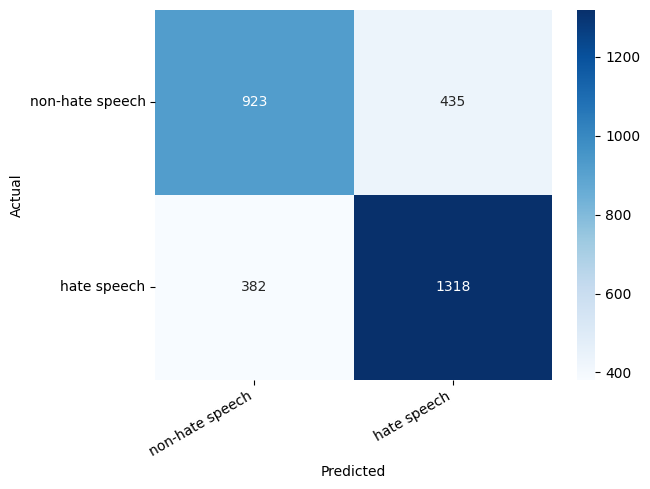

In [ ]:
if quantized == False:
  def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = 'right')
    plt.ylabel('Actual')
    plt.xlabel('Predicted');

  cm = confusion_matrix(bd_actual, bd_pred)

  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  show_confusion_matrix(df_cm)

###### **Researcher Dataset**

In [ ]:
if quantized == False:
  print("Accuracy: ", metrics.accuracy_score(rs_actual, rs_pred))
  print("F1 score (Micro): ", metrics.f1_score(rs_actual, rs_pred, average = 'micro'))
  print("F1 score (Macro):", metrics.f1_score(rs_actual, rs_pred, average = 'macro'))
  print("Hamming Loss: ", metrics.hamming_loss(rs_actual, rs_pred))
  print("\nClassification Report: \n", classification_report(rs_actual, rs_pred, target_names = class_names))
  print("\nMatthews Correlation Coefficient: ", metrics.matthews_corrcoef(rs_actual, rs_pred))

Accuracy:  0.6314858490566038
F1 score (Micro):  0.6314858490566038
F1 score (Macro): 0.6105757343861995
Hamming Loss:  0.36851415094339623

Classification Report: 
                  precision    recall  f1-score   support

non-hate speech       0.83      0.61      0.70      1208
    hate speech       0.42      0.69      0.52       488

       accuracy                           0.63      1696
      macro avg       0.62      0.65      0.61      1696
   weighted avg       0.71      0.63      0.65      1696


Matthews Correlation Coefficient:  0.27240332087773933


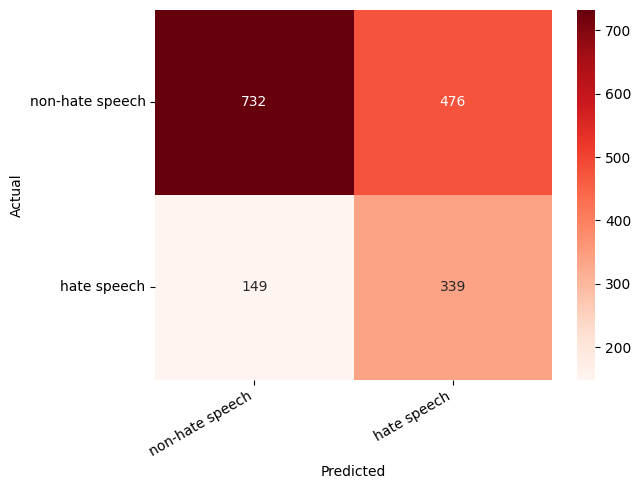

In [ ]:
if quantized == False:
  def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Reds")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = 'right')
    plt.ylabel('Actual')
    plt.xlabel('Predicted');

  cm = confusion_matrix(rs_actual, rs_pred)

  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  show_confusion_matrix(df_cm)

##### **Quantized**

###### **Benchmark Dataset**

In [ ]:
if quantized == True:
  print("Accuracy: ", metrics.accuracy_score(bd_actual, bd_pred))
  print("F1 score (Micro): ", metrics.f1_score(bd_actual, bd_pred, average = 'micro'))
  print("F1 score (Macro):", metrics.f1_score(bd_actual, bd_pred, average = 'macro'))
  print("Hamming Loss: ", metrics.hamming_loss(bd_actual, bd_pred))
  print("\nClassification Report: \n", classification_report(bd_actual, bd_pred, target_names = class_names))
  print("\nMatthews Correlation Coefficient: ", metrics.matthews_corrcoef(bd_actual, bd_pred))

Accuracy:  0.5742315238718116
F1 score (Micro):  0.5742315238718116
F1 score (Macro): 0.4967345706758025
Hamming Loss:  0.42576847612818836

Classification Report: 
                  precision    recall  f1-score   support

non-hate speech       0.56      0.20      0.30      1358
    hate speech       0.58      0.87      0.69      1700

       accuracy                           0.57      3058
      macro avg       0.57      0.54      0.50      3058
   weighted avg       0.57      0.57      0.52      3058



Matthews Correlation Coefficient: 0.09959 (as computed by https://www.omnicalculator.com/statistics/matthews-correlation-coefficient)

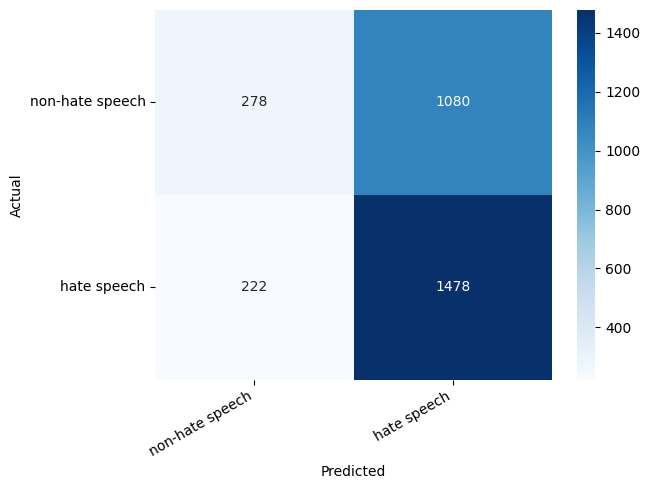

In [ ]:
if quantized == True:
  def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = 'right')
    plt.ylabel('Actual')
    plt.xlabel('Predicted');

  cm = confusion_matrix(bd_actual, bd_pred)

  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  show_confusion_matrix(df_cm)

###### **Researcher Dataset**

In [ ]:
if quantized == True:
  print("Accuracy: ", metrics.accuracy_score(rs_actual, rs_pred))
  print("F1 score (Micro): ", metrics.f1_score(rs_actual, rs_pred, average = 'micro'))
  print("F1 score (Macro):", metrics.f1_score(rs_actual, rs_pred, average = 'macro'))
  print("Hamming Loss: ", metrics.hamming_loss(rs_actual, rs_pred))
  print("\nClassification Report: \n", classification_report(rs_actual, rs_pred, target_names = class_names))
  print("\nMatthews Correlation Coefficient: ", metrics.matthews_corrcoef(rs_actual, rs_pred))

Accuracy:  0.3561320754716981
F1 score (Micro):  0.35613207547169806
F1 score (Macro): 0.33504810405814706
Hamming Loss:  0.6438679245283019

Classification Report: 
                  precision    recall  f1-score   support

non-hate speech       0.81      0.12      0.22      1208
    hate speech       0.30      0.93      0.45       488

       accuracy                           0.36      1696
      macro avg       0.56      0.53      0.34      1696
   weighted avg       0.66      0.36      0.28      1696


Matthews Correlation Coefficient:  0.07718838571165595


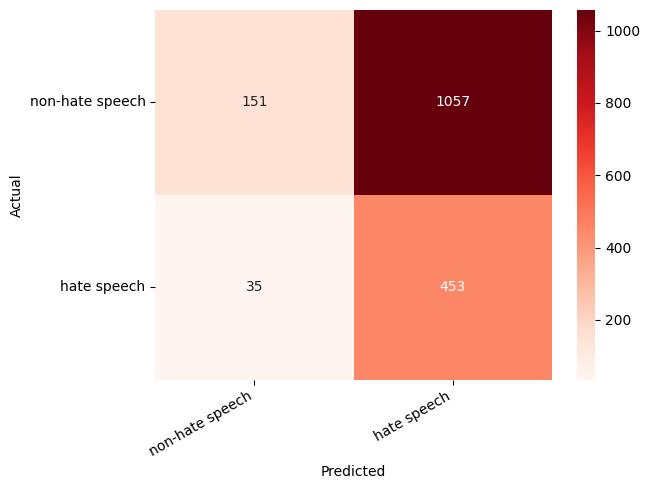

In [ ]:
if quantized == True:
  def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Reds")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = 'right')
    plt.ylabel('Actual')
    plt.xlabel('Predicted');

  cm = confusion_matrix(rs_actual, rs_pred)

  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  show_confusion_matrix(df_cm)